# 第2回目の着順予想
- 21/03/23に作成開始

## データ準備
- 全ての枠番のデータを一つの行にまとめる
- 統計量は何も入れない
- 枠番ごとにdfを分け、6つのdfそれぞれに対して分類を行う
### target 
- 1枠については、1着の場合1, 2着以降の場合は0に二値化
- ２枠以降については、3着以内であれば1、そうでなければ0に二値化
- これらをまとめて一つの行列にした上でモデルを作成

# 予測モデル
- 3_1でもっともAUCのスコアが高かったlight BGMのを用いて分類を実施する。

In [1]:
import pandas as pd

## データ準備
### データロード

In [2]:
race_df = pd.read_pickle('./arrangedData/data_formatted_1.pkl').reset_index(drop=True)

# 中身を確認
race_df

,date,venue,raceNumber,枠,num_false_start,num_late_start,racer_class,ボート2連率,ボート3連率,モーター2連率,...,temperature,tilt,water_temperature,wave_height,weight,wind_speed,着順,weather_曇り,weather_雨,weather_雪
0,2021-02-01,津,1.0,1,0,0,1,38.46,55.77,36.59,...,8.0,-0.5,6.0,1,52.2,1,1,1,0,0
1,2021-02-01,津,1.0,2,0,0,3,41.25,60.00,27.93,...,8.0,-0.5,6.0,1,53.1,1,2,1,0,0
2,2021-02-01,津,1.0,3,0,0,3,25.56,55.56,33.33,...,8.0,-0.5,6.0,1,53.2,1,3,1,0,0
3,2021-02-01,津,1.0,4,0,0,3,24.66,45.21,37.36,...,8.0,-0.5,6.0,1,52.7,1,4,1,0,0
4,2021-02-01,津,1.0,5,0,0,4,40.58,57.97,37.39,...,8.0,-0.5,6.0,1,52.9,1,5,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31081,2021-03-19,蒲 郡,12.0,2,0,0,1,44.75,67.58,37.10,...,15.0,-0.5,14.0,1,52.0,2,3,0,0,0
31082,2021-03-19,蒲 郡,12.0,3,0,0,1,25.47,40.99,34.47,...,15.0,-0.5,14.0,1,53.4,2,2,0,0,0
31083,2021-03-19,蒲 郡,12.0,4,0,0,1,44.68,64.36,39.66,...,15.0,-0.5,14.0,1,51.5,2,6,0,0,0
31084,2021-03-19,蒲 郡,12.0,5,0,0,1,34.83,48.76,34.76,...,15.0,-0.5,14.0,1,55.5,2,4,0,0,0


### 行をレースごとにまとめる（1-6枠のデータを1行にまとめる）

In [3]:
# レースごとに一つの情報しか持たない列と、枠番ごとに異なる情報をもつ列を分けて別のdfとする(date, venue, racenumberはindex的に用いる)
race_df_frame = race_df[['date', 'venue', 'raceNumber', '枠', 'num_false_start', 'num_late_start',
       'racer_class', 'ボート2連率', 'ボート3連率', 'モーター2連率', 'モーター3連率',
       'exhibitionTime', 'exhibition_ST', 'exhibition_cource', 'flying',
       'late', 'tilt', 'weight', '着順'
                       ]].set_index(['date', 'venue', 'raceNumber'])

race_df_race = race_df[['date', 'venue', 'raceNumber',
       'temperature', 'water_temperature', 'wave_height',
                       'wind_speed', 'weather_曇り', 'weather_雨'
                      ]]
race_df_race.drop_duplicates(inplace=True)
race_df_race.set_index(['date', 'venue', 'raceNumber'], inplace=True)

# 枠番ごとに異なる情報をもつ列について、枠番ごとのdfに分類した後で行方向にconcat
race_df_frame_list = []
for frame in range(1, 7):
    # 枠番を列名の末尾に付与
    race_df_frame_ = race_df_frame[race_df_frame["枠"]==frame].add_suffix("_{0}".format(frame))
    race_df_frame_list.append(race_df_frame_)

race_df_merged = pd.concat(race_df_frame_list, axis=1)

# レースごとに一つの情報しか持たない列をマージ
race_df_merged = pd.concat([race_df_merged, race_df_race], axis=1)
race_df_merged

<ipython-input-3-7fc284fbe60f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_df_race.drop_duplicates(inplace=True)


枠_1  num_false_start_1  num_late_start_1  \
date       venue raceNumber                                             
2021-02-01 　津　   1.0           1                  0                 0   
                 2.0           1                  0                 0   
                 3.0           1                  0                 0   
                 4.0           1                  1                 0   
                 5.0           1                  0                 0   
...                          ...                ...               ...   
2021-03-19 蒲　郡   8.0           1                  0                 0   
                 9.0           1                  1                 0   
                 10.0          1                  1                 0   
                 11.0          1                  1                 0   
                 12.0          1                  2                 0   

                             racer_class_1  ボート2連率_1  ボート3連率_1  モーター2連率_1  \
date       venue raceNumber                                                 
2021-02-01 　津　   1.0                     1     38.46     55.77      36.59   
                 2.0                     3     17.95     35.90      30.93   
                 3.0                     3     34.44     45.56      28.04   
                 4.0                     3     31.08     44.59      30.77   
                 5.0                     1     20.00     29.33      33.33   
...                                    ...       ...       ...        ...   
2021-03-19 蒲　郡   8.0                     2     41.29     62.19      35.47   
                 9.0                     2     32.32     51.52      30.99   
                 10.0                    1     41.33     58.16      31.13   
                 11.0                    1     34.50     53.80      33.03   
                 12.0                    1     27.37     41.34      33.64   

                             モーター3連率_1  exhibitionTime_1  exhibition_ST_1  \
date       venue raceNumber                                                 
2021-02-01 　津　   1.0             57.32              6.66             0.05   
                 2.0             43.30              6.70             0.09   
                 3.0             44.86              6.72             0.02   
                 4.0             51.65              6.67             0.03   
                 5.0             47.62              6.71             0.03   
...                                ...               ...              ...   
2021-03-19 蒲　郡   8.0             51.72              6.81             0.14   
                 9.0             47.89              6.81             0.11   
                 10.0            55.19              6.75             0.04   
                 11.0            51.83              6.81             0.02   
                 12.0            49.53              6.81             0.04   

                             ...  late_6  tilt_6  weight_6  着順_6  temperature  \
date       venue raceNumber  ...                                                
2021-02-01 　津　   1.0         ...       0    -0.5      52.0     6          8.0   
                 2.0         ...       0    -0.5      52.0     4          6.0   
                 3.0         ...       0    -0.5      50.0     6          6.0   
                 4.0         ...       0    -0.5      52.5     6          6.0   
                 5.0         ...       0    -0.5      53.2     6          6.0   
...                          ...     ...     ...       ...   ...          ...   
2021-03-19 蒲　郡   8.0         ...       0    -0.5      47.2     4         15.0   
                 9.0         ...       0    -0.5      52.5     6         15.0   
                 10.0        ...       0    -0.5      56.3     5         14.0   
                 11.0        ...       0    -0.5      53.6     6         15.0   
                 12.0        ...       0    -0.5      53.9     5         15.0   

                     

### rank列を作成し、inputにできない列を削除
- 1枠は1着ならば1, そうでなければ0
- 2枠以降については、3着以内なら1, そうでなければ0
- inputにできない列を削除

In [4]:
# 4枠は3着以内ならば1, そうでなければ0
race_df_merged_1 = race_df_merged.copy()

race_df_merged_1.loc[race_df_merged_1["着順_5"] < 4, "rank_5"] = 1
race_df_merged_1.loc[race_df_merged_1["着順_5"] > 3, "rank_5"] = 0

race_df_merged_1.reset_index(inplace=True)

# inputにできない列を削除
drop_columns = ["着順_{0}".format(i) for i in range(1, 7)] + ["枠_{0}".format(i) for i in range(1, 7)] + ["date", "venue", "raceNumber"]
race_df_merged_1.drop(drop_columns, axis=1, inplace=True)

race_df_merged_1

,num_false_start_1,num_late_start_1,racer_class_1,ボート2連率_1,ボート3連率_1,モーター2連率_1,モーター3連率_1,exhibitionTime_1,exhibition_ST_1,exhibition_cource_1,...,late_6,tilt_6,weight_6,temperature,water_temperature,wave_height,wind_speed,weather_曇り,weather_雨,rank_5
0,0,0,1,38.46,55.77,36.59,57.32,6.66,0.05,1,...,0,-0.5,52.0,8.0,6.0,1,1,1,0,0.0
1,0,0,3,17.95,35.90,30.93,43.30,6.70,0.09,1,...,0,-0.5,52.0,6.0,6.0,1,1,1,0,0.0
2,0,0,3,34.44,45.56,28.04,44.86,6.72,0.02,1,...,0,-0.5,50.0,6.0,6.0,1,2,1,0,0.0
3,1,0,3,31.08,44.59,30.77,51.65,6.67,0.03,1,...,0,-0.5,52.5,6.0,6.0,1,1,0,0,1.0
4,0,0,1,20.00,29.33,33.33,47.62,6.71,0.03,1,...,0,-0.5,53.2,6.0,6.0,1,2,1,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5176,0,0,2,41.29,62.19,35.47,51.72,6.81,0.14,1,...,0,-0.5,47.2,15.0,14.0,1,3,0,0,0.0
5177,1,0,2,32.32,51.52,30.99,47.89,6.81,0.11,1,...,0,-0.5,52.5,15.0,14.0,1,2,0,0,1.0
5178,1,0,1,41.33,58.16,31.13,55.19,6.75,0.04,1,...,0,-0.5,56.3,14.0,14.0,1,2,0,0,0.0
5179,1,0,1,34.50,53.80,33.03,51.83,6.81,0.02,1,...,0,-0.5,53.6,15.0,14.0,1,2,0,0,0.0


### training dataとtest dataに分ける

In [5]:
from sklearn.model_selection import train_test_split

X = race_df_merged_1.drop("rank_5", axis=1)
y = race_df_merged_1["rank_5"]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.3)

## Logistic回帰

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression() # ロジスティック回帰モデルのインスタンスを作成
model_lr.fit(X_train, y_train) # ロジスティック回帰モデルの重みを学習

/Users/grice/opt/anaconda3/envs/boatrace2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

### 性能評価

In [7]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

y_pred_lr = model_lr.predict(X_test)

print('confusion matrix = \n', confusion_matrix(y_true=y_test, y_pred=y_pred_lr))
print('accuracy = ', accuracy_score(y_true=y_test, y_pred=y_pred_lr))
print('precision = ', precision_score(y_true=y_test, y_pred=y_pred_lr))
print('recall = ', recall_score(y_true=y_test, y_pred=y_pred_lr))
print('f1 score = ', f1_score(y_true=y_test, y_pred=y_pred_lr))

confusion matrix = 
 [[938  86]
 [403 128]]
accuracy =  0.6855305466237942
precision =  0.5981308411214953
recall =  0.24105461393596986
f1 score =  0.3436241610738255


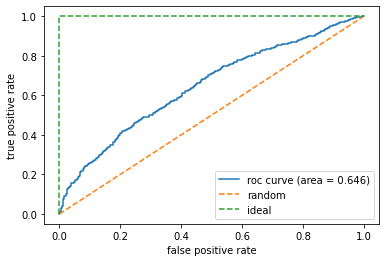

In [8]:
%matplotlib inline
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_score_lr = model_lr.predict_proba(X_test)[:, 1] # 検証データがクラス1に属する確率
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_score_lr)

plt.plot(fpr, tpr, label='roc curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], linestyle='--', label='random')
plt.plot([0, 0, 1], [0, 1, 1], linestyle='--', label='ideal')
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()

### 回帰係数を表示

In [9]:
pd.Series(model_lr.coef_[0], index=X_train.columns).sort_values()

racer_class_5         -0.770690
num_false_start_5     -0.162625
exhibition_cource_5   -0.084967
flying_6              -0.069702
exhibitionTime_5      -0.045875
                         ...   
racer_class_2          0.060155
racer_class_1          0.065716
racer_class_4          0.157278
racer_class_3          0.185261
racer_class_6          0.241845
Length: 90, dtype: float64

## RandomForest Classification

In [10]:
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(random_state=100)
model_rf.fit(X_train, y_train)

RandomForestClassifier(random_state=100)

### 性能評価

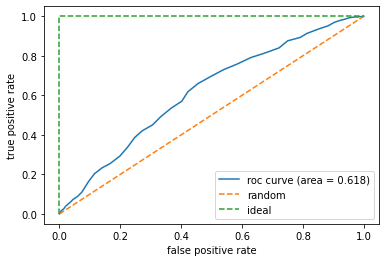

In [11]:
y_score_rf = model_rf.predict_proba(X_test)[:, 1] # 検証データがクラス1に属する確率
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_score_rf)

plt.plot(fpr, tpr, label='roc curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], linestyle='--', label='random')
plt.plot([0, 0, 1], [0, 1, 1], linestyle='--', label='ideal')
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()

In [12]:
# 過学習の確認用
from sklearn.metrics import roc_auc_score

print('auc = ', roc_auc_score(y_true=y_train, y_score=model_rf.predict_proba(X_train)[:, 1] ))

auc =  1.0


### パラメータ調整

In [13]:
rf_params = {
    "min_samples_split": 400,
    "max_depth": None,
    "random_state": 100
}
# "n_estimators": 60
# "criterion": "entropy",
# "class_weight": "balanced",

model_rf = RandomForestClassifier(**rf_params)
model_rf.fit(X_train, y_train)

print('auc_train = ', roc_auc_score(y_true=y_train, y_score=model_rf.predict_proba(X_train)[:, 1]))
print('auc_test = ', roc_auc_score(y_true=y_test, y_score=model_rf.predict_proba(X_test)[:, 1]))

auc_train =  0.7601939676635328
auc_test =  0.6438213571092279


### 回帰係数的な

In [14]:
pd.DataFrame({"features": X_train.columns, "importance": model_rf.feature_importances_}).sort_values("importance", ascending=False)

,features,importance
58,racer_class_5,0.211149
61,モーター2連率_5,0.045118
63,exhibitionTime_5,0.044260
69,weight_5,0.037368
5,モーター2連率_1,0.025490
...,...,...
52,flying_4,0.000000
53,late_4,0.000000
57,num_late_start_5,0.000000
66,flying_5,0.000000


## 勾配ブースティング木

In [19]:
import lightgbm as lgb

params = {"num_leaves": 2,
          "n_estimators": 100,
          "class_weight": "balanced",
          "random_state": 100
         }
# "min_data_in_leaf": 

model_lgb = lgb.LGBMClassifier(**params)
model_lgb.fit(X_train, y_train)

print('auc_train = ', roc_auc_score(y_true=y_train, y_score=model_lgb.predict_proba(X_train)[:, 1]))
print('auc_test = ', roc_auc_score(y_true=y_test, y_score=model_lgb.predict_proba(X_test)[:, 1]))

y_pred_lgb = model_lgb.predict(X_test)
print('confusion matrix = \n', confusion_matrix(y_true=y_test, y_pred=y_pred_lgb))
print('accuracy = ', accuracy_score(y_true=y_test, y_pred=y_pred_lgb))
print('precision = ', precision_score(y_true=y_test, y_pred=y_pred_lgb))
print('recall = ', recall_score(y_true=y_test, y_pred=y_pred_lgb))
print('f1 score = ', f1_score(y_true=y_test, y_pred=y_pred_lgb))

auc_train =  0.6790432696060356
auc_test =  0.6501726915607344
confusion matrix = 
 [[658 366]
 [230 301]]
accuracy =  0.6167202572347267
precision =  0.4512743628185907
recall =  0.5668549905838042
f1 score =  0.5025041736227045


In [17]:
pd.DataFrame({"features": X_train.columns, "importance": model_lgb.feature_importances_}).sort_values("importance", ascending=False)

,features,importance
58,racer_class_5,34
72,racer_class_6,9
63,exhibitionTime_5,9
30,racer_class_3,8
34,モーター3連率_3,6
...,...,...
31,ボート2連率_3,0
29,num_late_start_3,0
28,num_false_start_3,0
27,weight_2,0
